In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
from fastai.vision.all import *

In [11]:
ims = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz')

In [12]:
ims.ls()

(#4) [Path('/root/.fastai/data/oxford-102-flowers/jpg'),Path('/root/.fastai/data/oxford-102-flowers/test.txt'),Path('/root/.fastai/data/oxford-102-flowers/valid.txt'),Path('/root/.fastai/data/oxford-102-flowers/train.txt')]

In [13]:
df = pd.read_csv(f'{ims}/train.txt',sep=' ',names = ['fname','label'])
df['is_valid'] = False
print(df.shape)

df.head()

(1020, 3)


,fname,label,is_valid
0,jpg/image_03860.jpg,16,False
1,jpg/image_06092.jpg,13,False
2,jpg/image_02400.jpg,42,False
3,jpg/image_02852.jpg,55,False
4,jpg/image_07710.jpg,96,False


In [14]:
df_val = pd.read_csv(f'{ims}/valid.txt',sep=' ',names = ['fname','label'])
df_val['is_valid'] = True
print(df_val.shape)
df_val.head()

(1020, 3)


,fname,label,is_valid
0,jpg/image_04467.jpg,89,True
1,jpg/image_07129.jpg,44,True
2,jpg/image_05166.jpg,4,True
3,jpg/image_07002.jpg,34,True
4,jpg/image_02007.jpg,79,True


In [15]:
df = pd.concat([df,df_val])
df.head()

,fname,label,is_valid
0,jpg/image_03860.jpg,16,False
1,jpg/image_06092.jpg,13,False
2,jpg/image_02400.jpg,42,False
3,jpg/image_02852.jpg,55,False
4,jpg/image_07710.jpg,96,False


In [16]:
df.fname = df.fname.apply(lambda x:f'{ims}/{x}')
df.head()

,fname,label,is_valid
0,/root/.fastai/data/oxford-102-flowers/jpg/image_03860.jpg,16,False
1,/root/.fastai/data/oxford-102-flowers/jpg/image_06092.jpg,13,False
2,/root/.fastai/data/oxford-102-flowers/jpg/image_02400.jpg,42,False
3,/root/.fastai/data/oxford-102-flowers/jpg/image_02852.jpg,55,False
4,/root/.fastai/data/oxford-102-flowers/jpg/image_07710.jpg,96,False


In [17]:
item_tfms = [RandomResizedCrop(500,min_scale=0.75, ratio=(1.,1.))]
batch_tfms = [*aug_transforms(size=244),Normalize.from_stats(*imagenet_stats)]

In [18]:
dblock = DataBlock((ImageBlock,CategoryBlock),
                   get_x=ColReader('fname'),
                   get_y = ColReader('label'),
                   item_tfms = item_tfms,
                   batch_tfms=batch_tfms,
                   splitter=ColSplitter()                  
                  )

In [19]:
dls = dblock.dataloaders(df)

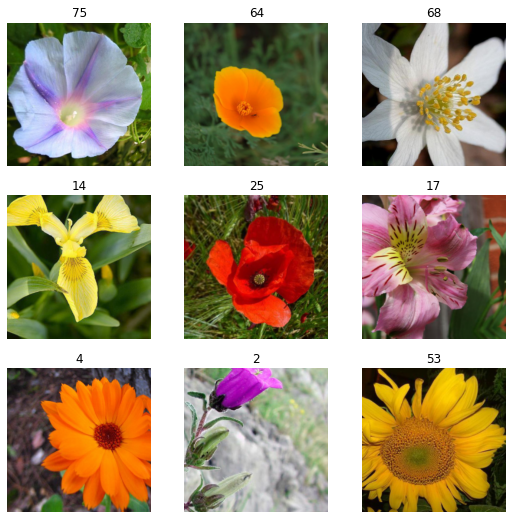

In [20]:
dls.show_batch()

In [21]:
learn = cnn_learner(dls,resnet50,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

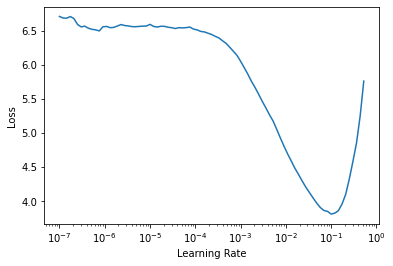

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(3,lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,3.824965,2.234219,0.526471,00:26
1,2.171198,1.022346,0.730392,00:23
2,1.391051,0.704259,0.809804,00:25


In [24]:
learn.unfreeze()

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.737800812406931e-05)

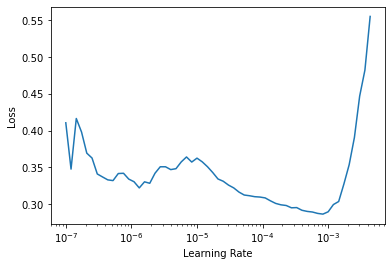

In [25]:
learn.lr_find()

In [26]:
learn.save('s-1')

Path('models/s-1.pth')

In [29]:
learn = learn.load('./s-1')

In [30]:
learn.fit_one_cycle(5,lr_max=slice(1e-6,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.361526,0.660000,0.820588,00:25
1,0.313631,0.605230,0.842157,00:25
2,0.264654,0.572639,0.843137,00:24
3,0.222139,0.559848,0.850980,00:25
4,0.201504,0.558037,0.852941,00:24


In [42]:
df_test = pd.read_csv(f'{ims}/test.txt',sep=' ',names=['fname','label'])

df_test.fname = df_test.fname.apply(lambda x:f'{ims}/{x}')
df_test.head()

,fname,label
0,/root/.fastai/data/oxford-102-flowers/jpg/image_06977.jpg,34
1,/root/.fastai/data/oxford-102-flowers/jpg/image_00800.jpg,80
2,/root/.fastai/data/oxford-102-flowers/jpg/image_05038.jpg,58
3,/root/.fastai/data/oxford-102-flowers/jpg/image_06759.jpg,0
4,/root/.fastai/data/oxford-102-flowers/jpg/image_01133.jpg,45


In [90]:
test_dl = dls.test_dl(df_test,with_labels=True)

In [91]:
preds,targs = learn.tta(dl=test_dl)

In [92]:
accuracy(preds,targs)

TensorCategory(0.8518)